In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

nodenum = 4
coinsiz = 2
thetanum = 4
e = list(range(1, nodenum))
print(e)

[1, 2, 3]


In [2]:
def GroverCoin(qc):
    # Grover Coin operator
    lis = list(range(nodenum, nodenum+coinsiz))
    qc.h(lis)
    qc.z(lis)
    qc.cz(nodenum,nodenum-1+coinsiz)
    qc.h(lis)
    return qc

def HadamarCoin(qc):
    lis = list(range(nodenum, nodenum+coinsiz))
    qc.h(lis)
    qc.cx(nodenum,nodenum-1+coinsiz)
    return qc

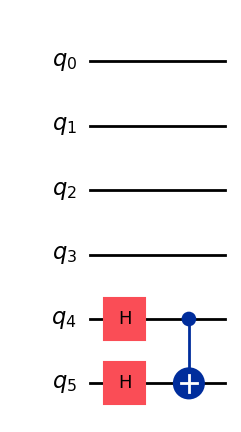

In [3]:
one_step_circuit = QuantumCircuit(nodenum+coinsiz, name=' ONE STEP') 
one_step_circuit = HadamarCoin(one_step_circuit)
#one_step_circuit = GroverCoin(one_step_circuit)
one_step_circuit.draw('mpl') 


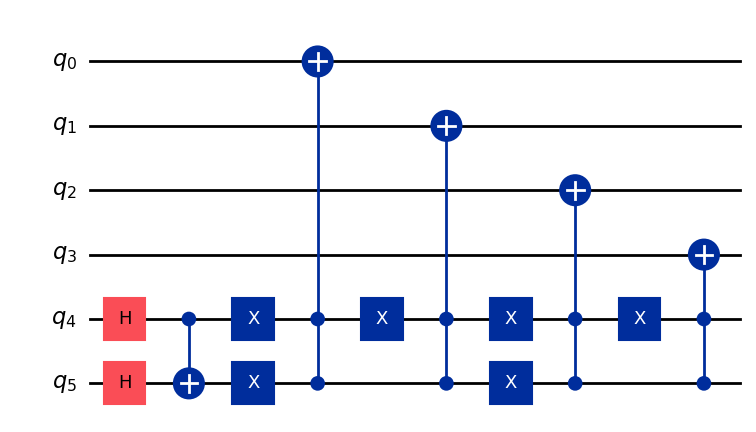

In [4]:
# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,nodenum):
        circuit.x(nodenum)
        if i%2==0:
            circuit.x(nodenum+1)
        circuit.ccx(nodenum,nodenum+1,i)

def shift2(circuit):
    circuit.x(2)
    circuit.ccx(2,3,0)
    circuit.x(2)
    circuit.ccx(2,3,1)

def shift3(circuit):
    circuit.x(4)
    circuit.ccx(3,4,0)
    circuit.x([3,4])
    circuit.ccx(3,4,1)
    circuit.x(3)
    circuit.ccx(3,4,2)



#shift3(one_step_circuit)
shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw('mpl') 

In [5]:

# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

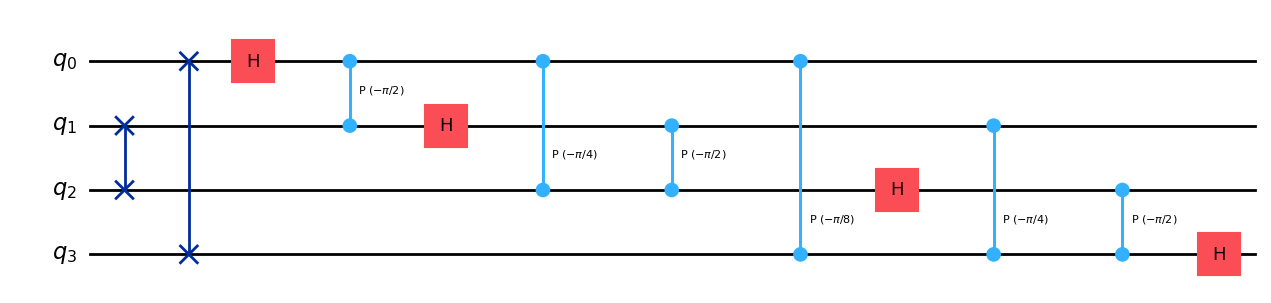

In [6]:
inv_qft_gate = QFT(thetanum, inverse=True).to_instruction()  
qft_gate = QFT(thetanum, inverse=False).to_instruction()

QFT(thetanum, inverse=True).decompose().draw("mpl")

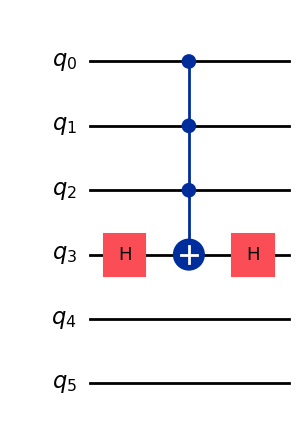

In [7]:
from qiskit.circuit.library import MCXGate
phase_circuit =  QuantumCircuit(nodenum+2, name=' phase oracle ')
# Mark 1011
#phase_circuit.x(2)
#phase_circuit.h(3)
#phase_circuit.mcx([0,1,2], 3)
#phase_circuit.h(3)
#phase_circuit.x(2)
# Mark 1111
phase_circuit.h(nodenum-1)
phase_circuit.mcx(list(range(nodenum-1)),nodenum-1)
phase_circuit.h(nodenum-1)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(thetanum+nodenum+2+1, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, list(range(thetanum, thetanum+nodenum+2)))
phase_circuit.draw('mpl') 

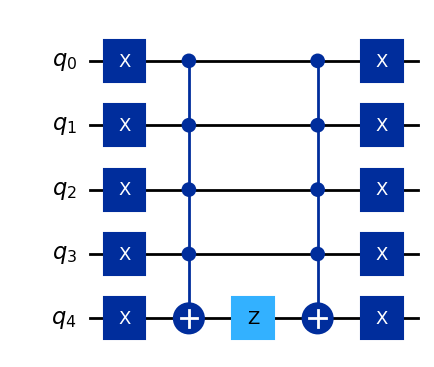

In [8]:
# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(thetanum+1, name=' mark auxiliary ')
lis = list(range(thetanum+1))
lis2 = list(range(thetanum))
mark_auxiliary_circuit.x(lis)
mark_auxiliary_circuit.mcx(lis2, thetanum)
mark_auxiliary_circuit.z(thetanum)
mark_auxiliary_circuit.mcx(lis2, thetanum)
mark_auxiliary_circuit.x(lis)

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw('mpl')

In [9]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(thetanum+nodenum+2+1, name=' phase estimation ')
lis2 = list(range(thetanum))
lis = list(range(thetanum, thetanum+nodenum+2))
phase_estimation_circuit.h(lis2)
for i in range(0,thetanum):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i] + lis)

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, lis2)

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, lis2+[nodenum+thetanum+2])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, lis2)   

for i in range(thetanum-1,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i] + lis)
phase_estimation_circuit.barrier(range(0,nodenum+thetanum+2))
phase_estimation_circuit.h(lis2)

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
#phase_estimation_circuit.draw('mpl') 

In [26]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(thetanum, 'theta')
node_q = QuantumRegister(nodenum, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(nodenum, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
lis = list(range(thetanum, thetanum+nodenum+2))
lis2 = list(range(thetanum+nodenum+2+1))
circuit.h(lis)
iterations = 10

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, lis)
    circuit.append(phase_estimation_gate, lis2)

for i in range(nodenum):
    circuit.measure(node_q[i], creg_c2[i])
#circuit.draw('mpl')

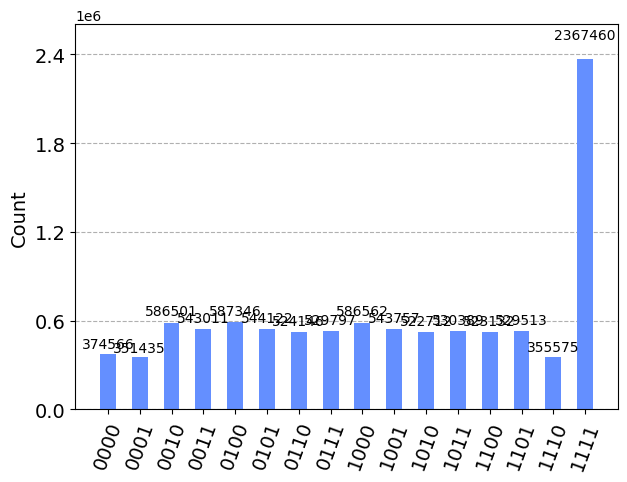

In [27]:

from qiskit_aer import AerSimulator
from qiskit_aer import StatevectorSimulator
circuit = circuit.decompose(reps=20) #it doesn't understand big instuctions, so you have to break it up for the simulator.
job = AerSimulator().run(circuits=circuit, shots=10000024)
#job = StatevectorSimulator().run(circuits=circuit, shots=1024)
hist = job.result().get_counts() 
plot_histogram( hist )